# File Downloading

In [1]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/ #import Kaggle token from Kaggle.com

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:08<00:00, 235MB/s]
100% 1.06G/1.06G [00:08<00:00, 140MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Initialization and Defining

In [33]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math
import numpy as np

In [9]:
TRAIN_DATA_DIR = '/content/train'
VALIDATION_DATA_DIR = '/content/test'
TRAIN_SAMPLES = 500
VALIDATION_SAMPLES = 500
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 244, 244
BATCH_SIZE = 64

In [10]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 12345,
    class_mode = 'categorical'
)

validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle = False,
    seed = 12345,
    class_mode = 'categorical'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Creating CNN model

In [12]:
def model_maker():
    base_model = MobileNet(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False # Freeze the layers
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [75]:
model = model_maker()
model.summary()

<ipython-input-12-489749badce1>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,294,594 (12.57 MB)

 Trainable params: 65,730 (256.76 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [76]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics =['acc'])

#Number of steps
num_steps = math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)

history = model.fit(train_generator,
                    steps_per_epoch = num_steps,
                    epochs=10,
                    validation_data = validation_generator,
                    validation_steps = num_steps)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - acc: 0.6905 - loss: 0.6726 - val_acc: 0.9785 - val_loss: 0.0598
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - acc: 0.8795 - loss: 0.2798 - val_acc: 0.9512 - val_loss: 0.1287
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - acc: 0.9078 - loss: 0.1870 - val_acc: 0.9844 - val_loss: 0.0516
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - acc: 0.9406 - loss: 0.1795 - val_acc: 0.9434 - val_loss: 0.1671
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - acc: 0.9515 - loss: 0.1459 - val_acc: 0.9727 - val_loss: 0.0781
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - acc: 0.9517 - loss: 0.1154 - val_acc: 0.9844 - val_loss: 0.0513
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - acc: 0.9557 - loss: 0.1095 - val_acc: 0.9805 - val_loss: 0.0476
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - acc: 0.9640 - loss: 0.0877 - val_acc: 0.9648 - val_loss: 0.0751
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - acc: 0.9659 - loss: 0.0748 - val_acc: 0.98

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


# Plots

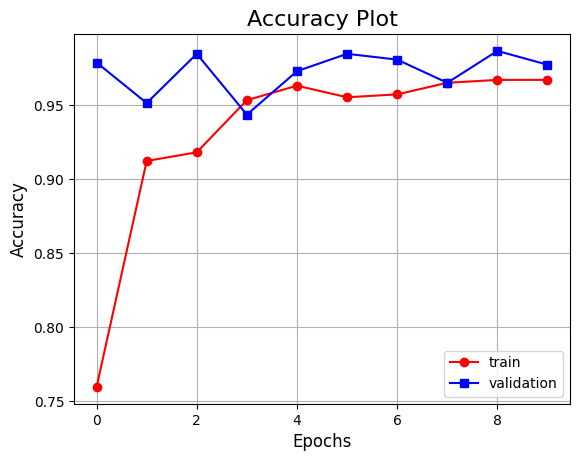

In [77]:
import matplotlib.pyplot as plt
plt.title('Accuracy Plot', fontsize=16)
plt.plot(history.history['acc'], '-o', color = 'red', label = 'train')
plt.plot(history.history['val_acc'], '-s', color = 'blue', label = 'validation')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

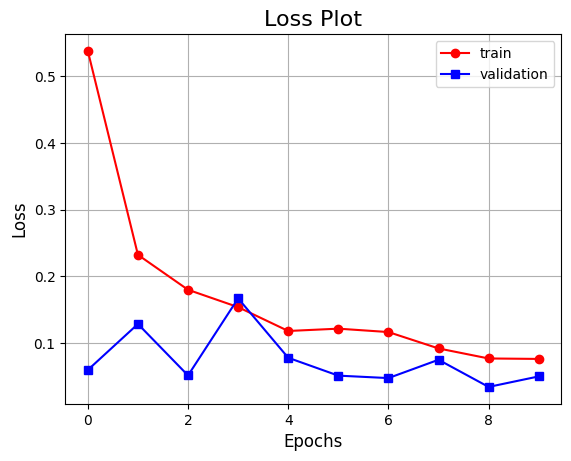

In [78]:
plt.title('Loss Plot', fontsize=16)
plt.plot(history.history['loss'], '-o', color = 'red', label = 'train')
plt.plot(history.history['val_loss'], '-s', color = 'blue', label = 'validation')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

# Prediction

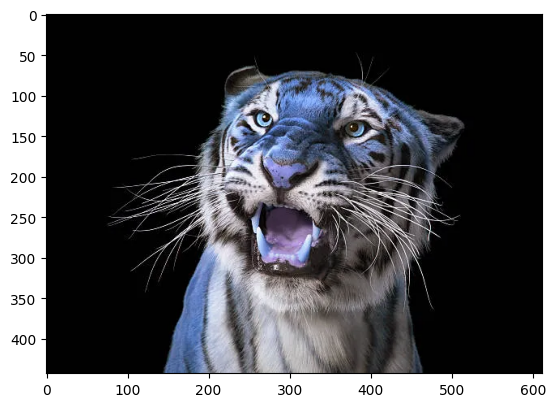

In [82]:
import cv2
test_img = cv2.imread('/content/tiger.webp')
plt.imshow(test_img)

In [83]:
test_img = cv2.resize(test_img,(244,244)) # Resize the image to 244x244 pixels
test_input = test_img.reshape((1,244,244,3))

In [84]:
preprocessed_img = preprocess_input(test_input) # Preprcess the image
prediction = model.predict(preprocessed_img)

# print(prediction)
# print(validation_generator.class_indices)

if prediction[0][0] > prediction[0][1]:
  print('cat')
else:
  print('dog')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
cat


#### Author: **Tushar Rajput**

- X - @iam_tsr
- LinkedIn - https://www.linkedin.com/in/imtsr/